In [6]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [7]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data loading and preparation

## load

In [8]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [34]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
48it [00:00, 231.42it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 203.82it/s]


### tfidf

In [10]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Clustering
Start with default params and tied for the covariance type because of the high CPU and RAM usage with full.

In [18]:
def fit_model(model, corpus):
    model.fit(corpus)

def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, vectorizer, corpus, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(np.max(model.labels_)+1):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(model.labels_ == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters
    
model = Birch()
fit_model(model, tfidf_corpus.toarray())
clusters = print_and_get_clusters(model, vectorizer, corpus)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
('learning', 'algorithm', 'model', 'data', 'method', 'problem', 'function', 'kernel', 'regression', 'network')


Cluster 1:
('model', 'algorithm', 'graph', 'matrix', 'data', 'method', 'clustering', 'learning', 'gaussian', 'problem')


Cluster 2:
('causal', 'effect', 'data', 'variable', 'model', 'method', 'discovery', 'approach', 'algorithm', 'learning')




when using found subclusters there are only 3 clusters present.

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


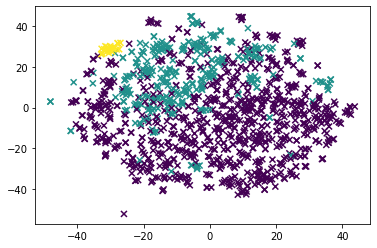

In [19]:
def plot(model, corpus, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()
plot(model, tfidf_corpus)

cluster looks good, but there are only very few clusters

# Remove words which appear often in all clusters

In [20]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'learning': 3, 'algorithm': 3, 'model': 3, 'data': 3, 'method': 3, 'problem': 2, 'function': 1, 'kernel': 1, 'regression': 1, 'network': 1, 'graph': 1, 'matrix': 1, 'clustering': 1, 'gaussian': 1, 'causal': 1, 'effect': 1, 'variable': 1, 'discovery': 1, 'approach': 1})>

most common words are similar to kmeans

In [21]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
corpus = load_data()

corpus_stopwords = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
41it [00:00, 197.78it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 200.83it/s]


In [23]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
model_stopwords = Birch()
fit_model(model_stopwords, tfidf_corpus_stopwords)
clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, corpus_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
('problem', 'matrix', 'kernel', 'function', 'network', 'based', 'graph', 'approach', 'set', 'regression')


Cluster 1:
('causal', 'effect', 'variable', 'discovery', 'approach', 'cause', 'inference', 'instrumental', 'assumption', 'non')


Cluster 2:
('stochastic', 'convex', 'distributed', 'optimization', 'problem', 'gradient', 'function', 'convergence', 'non', 'regression')




3 clusters seem to be not enough?

In [30]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'problem': 2, 'function': 2, 'approach': 2, 'regression': 2, 'non': 2, 'matrix': 1, 'kernel': 1, 'network': 1, 'based': 1, 'graph': 1, 'set': 1, 'causal': 1, 'effect': 1, 'variable': 1, 'discovery': 1, 'cause': 1, 'inference': 1, 'instrumental': 1, 'assumption': 1, 'stochastic': 1, 'convex': 1, 'distributed': 1, 'optimization': 1, 'gradient': 1, 'convergence': 1})>

Now there are other words, which could be removed

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


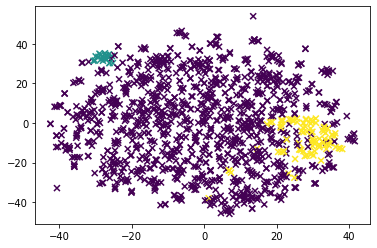

In [31]:
plot(model_stopwords, tfidf_corpus_stopwords)

nice clusters visible

# Try with more clusters


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
('learning', 'algorithm', 'method', 'model', 'problem', 'data', 'function', 'regression', 'bound', 'optimization')


Cluster 1:
('learning', 'data', 'model', 'algorithm', 'label', 'method', 'prediction', 'machine', 'task', 'set')


Cluster 2:
('clustering', 'density', 'cluster', 'algorithm', 'graph', 'estimation', 'based', 'data', 'spectral', 'matrix')


Cluster 3:
('model', 'algorithm', 'data', 'inference', 'method', 'gaussian', 'selection', 'time', 'variable', 'process')


Cluster 4:
('model', 'graphical', 'graph', 'lasso', 'algorithm', 'data', 'covariance', 'network', 'method', 'matrix')


Cluster 5:
('algorithm', 'convex', 'stochastic', 'gradient', 'problem', 'function', 'method', 'optimization', 'non', 'constraint')


Cluster 6:
('graph', 'vertex', 'kernel', 'random', 'learning', 'algorithm', 'problem', 'alexey', 'bibliography', 'nomination')


Cluster 7:
('kernel', 'distributed', 'rate', 'algorithm', 'learning', 'method', 'regression', 'data', 'b

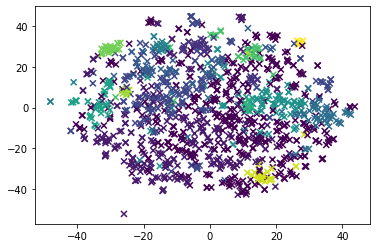

In [35]:
model_more_clusters = Birch(n_clusters = num_topics)
fit_model(model_more_clusters, tfidf_corpus.toarray())
clusters_more_clusters = print_and_get_clusters(model_more_clusters, vectorizer, corpus)
plot(model_more_clusters, tfidf_corpus)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
('machine', 'feature', 'problem', 'set', 'classification', 'class', 'task', 'classifier', 'prediction', 'time')


Cluster 1:
('graphical', 'lasso', 'selection', 'covariance', 'matrix', 'feature', 'sparse', 'change', 'high', 'gaussian')


Cluster 2:
('problem', 'label', 'online', 'function', 'regret', 'bound', 'set', 'constraint', 'ranking', 'multi')


Cluster 3:
('graph', 'dag', 'vertex', 'random', 'problem', 'time', 'markov', 'distribution', 'nomination', 'node')


Cluster 4:
('network', 'community', 'neural', 'layer', 'node', 'structure', 'cascade', 'detection', 'distribution', 'estimation')


Cluster 5:
('stochastic', 'convex', 'distributed', 'optimization', 'problem', 'gradient', 'function', 'convergence', 'non', 'regression')


Cluster 6:
('inference', 'process', 'time', 'variational', 'latent', 'bayesian', 'gaussian', 'distribution', 'variable', 'approach')


Cluster 7:
('kernel', 'mean', 'approximation', 'performance', 'estimator', 'class', 'dis

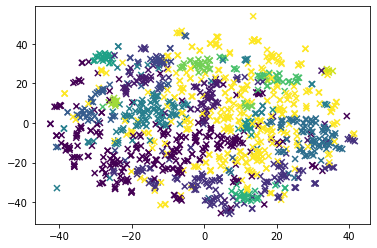

In [39]:
model_stopwords_more_clusters = Birch(n_clusters = num_topics)
fit_model(model_stopwords_more_clusters, tfidf_corpus_stopwords)
clusters_stopwords = print_and_get_clusters(model_stopwords_more_clusters, vectorizer_stopwords, corpus_stopwords)
plot(model_stopwords_more_clusters, tfidf_corpus_stopwords)

# Metrics
Metrics provided from sklearn, that don't need true labels:

    metrics.silhouette_score
    metrics.calinski_harabasz_score
    metrics.davies_bouldin_score
    
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [40]:
def calc_scores(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), model.labels_), metrics.davies_bouldin_score(corpus.toarray(), model.labels_)
scores = []
score = list(calc_scores(tfidf_corpus, model))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)
score = list(calc_scores(tfidf_corpus, model_more_clusters))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords_more_clusters))
score.insert(0, 'model with custom stopwords')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                    model type  silhouette_score  calinski_harabasz_score  \
0                 normal model          0.002453                 5.196730   
1  model with custom stopwords          0.000683                 5.120431   
2                 normal model          0.001654                 4.056009   
3  model with custom stopwords          0.003581                 4.157985   

   davies_bouldin_score  
0             10.386716  
1              6.641520  
2              6.833885  
3              6.990993  


silhouette score and calinski_harabasz_score impliy that it's getting better with the use of custom stopword removal. davies_bouldin_score not.
Also it seems that kmeans is better with the silhouette and the davies_bouldin_score but not with the calinski_harabasz_sore.